In [2]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Optional, Tuple

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

pl.enable_string_cache()
plt.rcParams["figure.dpi"] = 130


In [ ]:
@dataclass(frozen=True)
class VizConfig:
    cache_dir: Path = Path("data/cache")
    out_dir: Path = Path("data/cache/figures")

    # Artefactos
    macro_states: Path = Path("data/cache/macro_states.parquet")
    benchmark_monthly: Path = Path("data/cache/benchmark_monthly_clean.parquet")
    benchmark_forensics: Path = Path("data/cache/benchmark_forensics_by_regime.parquet")

    algos_meta: Path = Path("data/cache/algos_meta.parquet")
    algos_meta_good: Path = Path("data/cache/algos_meta_good.parquet")
    features_macro: Path = Path("data/cache/algos_features_macro.parquet")

    regime_profiles_long: Path = Path("data/cache/algo_regime_profiles_long.parquet")
    regime_profiles_wide: Path = Path("data/cache/algo_regime_profiles_wide.parquet")
    regime_rankings: Path = Path("data/cache/algo_regime_rankings.parquet")
    clusters: Path = Path("data/cache/algo_regime_clusters.parquet")

def ensure_out(cfg: VizConfig) -> None:
    cfg.out_dir.mkdir(parents=True, exist_ok=True)

cfg = VizConfig()
ensure_out(cfg)


In [4]:
REGIME_NAMES = {
    0: "Reflation",
    1: "Recovery",
    2: "Overheat",
    3: "Stagflation",
}

REGIME_COLORS = {
    0: "#1f77b4",  # azul
    1: "#2ca02c",  # verde
    2: "#ff7f0e",  # naranja
    3: "#d62728",  # rojo
}

def save_fig(cfg: VizConfig, name: str) -> None:
    path = cfg.out_dir / f"{name}.png"
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight")
    print("Saved:", path)

def _to_pandas(df: pl.DataFrame):
    return df.to_pandas()

def _read_parquet_or_raise(path: Path, label: str) -> pl.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"No existe {label}: {path}")
    return pl.read_parquet(str(path))


Saved: cache\figures\macro_timeseries.png


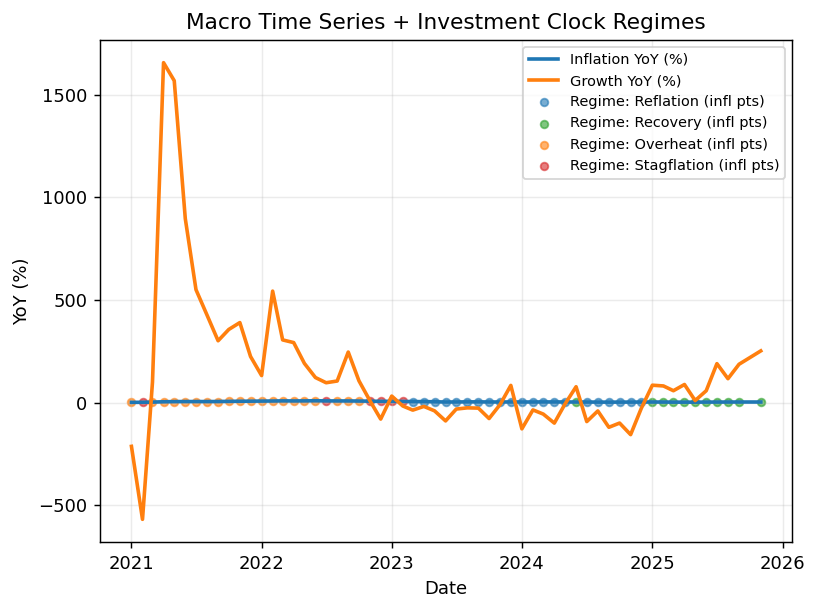

In [5]:
def plot_macro_timeseries(cfg: VizConfig) -> None:
    df = _read_parquet_or_raise(cfg.macro_states, "macro_states").sort("date")
    pdf = _to_pandas(df.select(["date", "inflation_yoy", "growth_yoy", "regime_id"]))

    fig, ax = plt.subplots()
    ax.plot(pdf["date"], pdf["inflation_yoy"], label="Inflation YoY (%)", linewidth=2)
    ax.plot(pdf["date"], pdf["growth_yoy"], label="Growth YoY (%)", linewidth=2)

    # sombreado por régimen
    # (pinta puntos con color; es más estable que spans si hay muchos cambios)
    for rid in sorted(REGIME_COLORS):
        m = (pdf["regime_id"] == rid)
        ax.scatter(pdf.loc[m, "date"], pdf.loc[m, "inflation_yoy"],
                   s=18, color=REGIME_COLORS[rid], alpha=0.6,
                   label=f"Regime: {REGIME_NAMES[rid]} (infl pts)")

    ax.set_title("Macro Time Series + Investment Clock Regimes")
    ax.set_xlabel("Date")
    ax.set_ylabel("YoY (%)")
    ax.legend(loc="best", fontsize=8)
    ax.grid(True, alpha=0.25)

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    save_fig(cfg, "macro_timeseries")
    plt.show()

plot_macro_timeseries(cfg)


Saved: cache\figures\regime_frequency.png


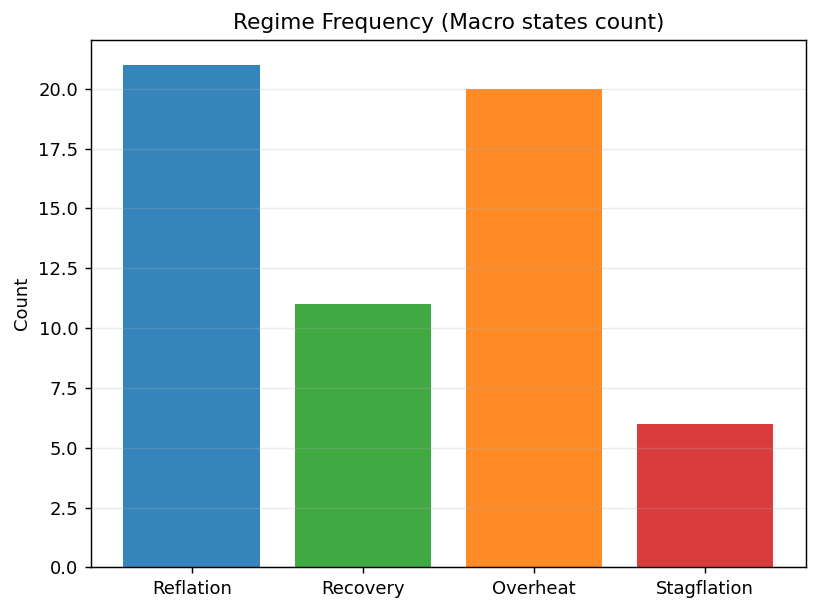

In [6]:
def plot_regime_frequency(cfg: VizConfig) -> None:
    df = _read_parquet_or_raise(cfg.macro_states, "macro_states")
    counts = (df.group_by("regime_id").len().sort("regime_id")).to_pandas()

    fig, ax = plt.subplots()
    xs = counts["regime_id"].to_numpy()
    ys = counts["len"].to_numpy()

    colors = [REGIME_COLORS[int(x)] for x in xs]
    labels = [REGIME_NAMES[int(x)] for x in xs]
    ax.bar(labels, ys, color=colors, alpha=0.9)

    ax.set_title("Regime Frequency (Macro states count)")
    ax.set_ylabel("Count")
    ax.grid(True, axis="y", alpha=0.25)
    save_fig(cfg, "regime_frequency")
    plt.show()

plot_regime_frequency(cfg)


Saved: cache\figures\benchmark_equity_curve.png


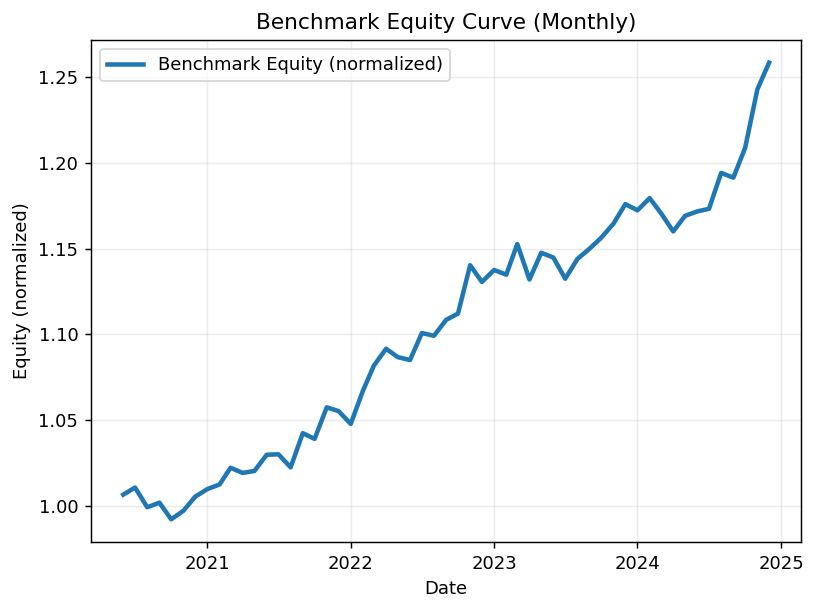

Saved: cache\figures\benchmark_monthly_returns.png


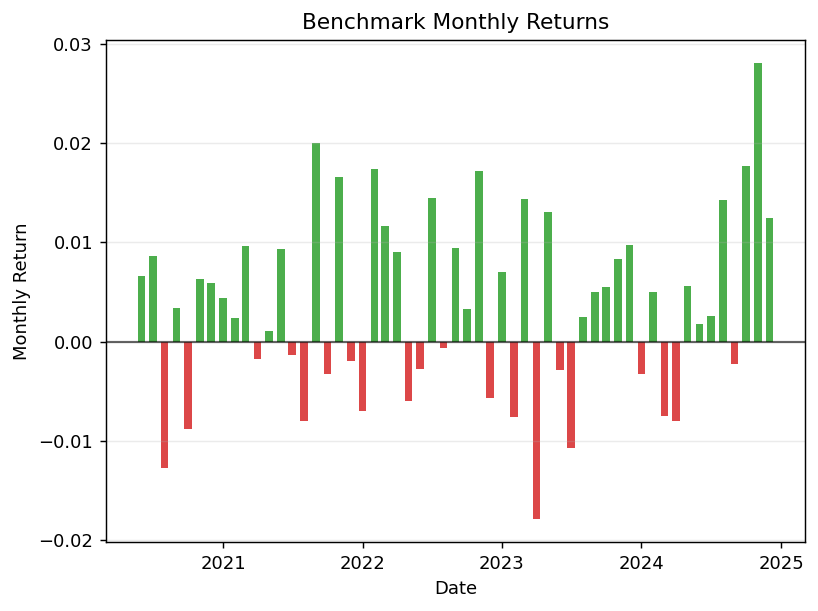

In [7]:
def plot_benchmark_equity_and_returns(cfg: VizConfig) -> None:
    df = _read_parquet_or_raise(cfg.benchmark_monthly, "benchmark_monthly_clean").sort("month_date")
    pdf = _to_pandas(df.select(["month_date", "start_equity", "end_equity", "monthly_return"]))

    # Equity normalizada
    eq0 = float(pdf["start_equity"].iloc[0])
    pdf["equity_norm"] = pdf["end_equity"] / eq0

    fig, ax = plt.subplots()
    ax.plot(pdf["month_date"], pdf["equity_norm"], linewidth=2.5, label="Benchmark Equity (normalized)")
    ax.set_title("Benchmark Equity Curve (Monthly)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Equity (normalized)")
    ax.grid(True, alpha=0.25)
    ax.legend(loc="best")

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    save_fig(cfg, "benchmark_equity_curve")
    plt.show()

    # Monthly returns bar (green/red)
    fig, ax = plt.subplots()
    ret = pdf["monthly_return"].to_numpy()
    colors = np.where(ret >= 0, "#2ca02c", "#d62728")
    ax.bar(pdf["month_date"], ret, color=colors, alpha=0.85, width=20)

    ax.set_title("Benchmark Monthly Returns")
    ax.set_xlabel("Date")
    ax.set_ylabel("Monthly Return")
    ax.axhline(0, linewidth=1.2, color="black", alpha=0.6)
    ax.grid(True, axis="y", alpha=0.25)

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    save_fig(cfg, "benchmark_monthly_returns")
    plt.show()

plot_benchmark_equity_and_returns(cfg)


Saved: cache\figures\benchmark_forensics_n_trades_open.png


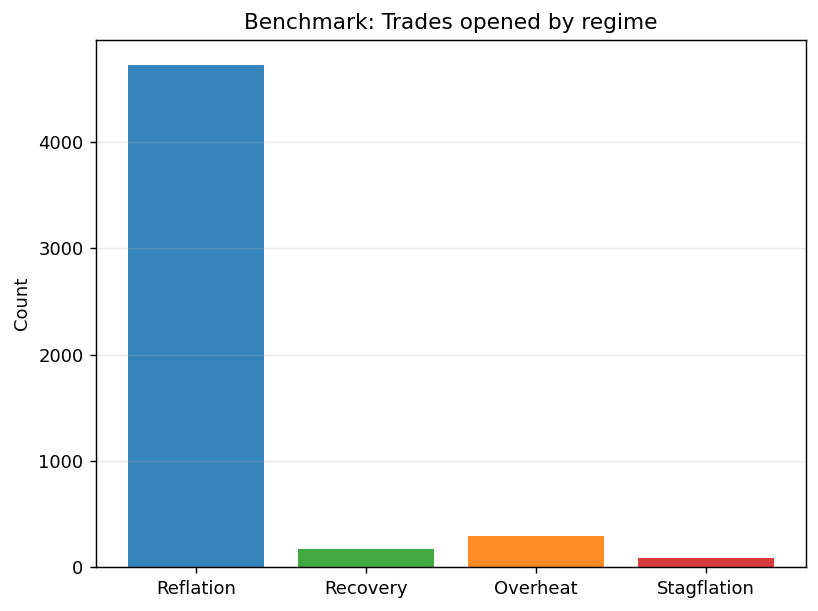

Saved: cache\figures\benchmark_forensics_unique_algos_traded.png


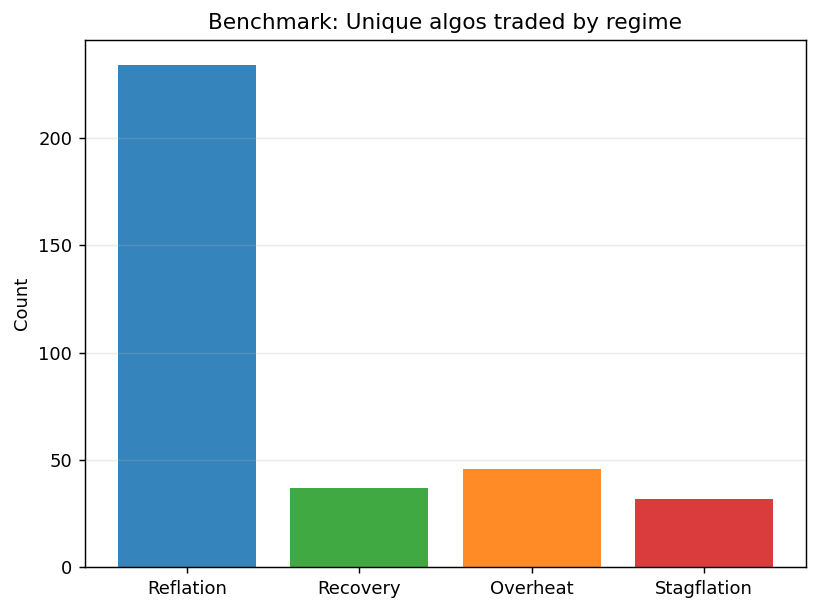

Saved: cache\figures\benchmark_forensics_avg_holding_days.png


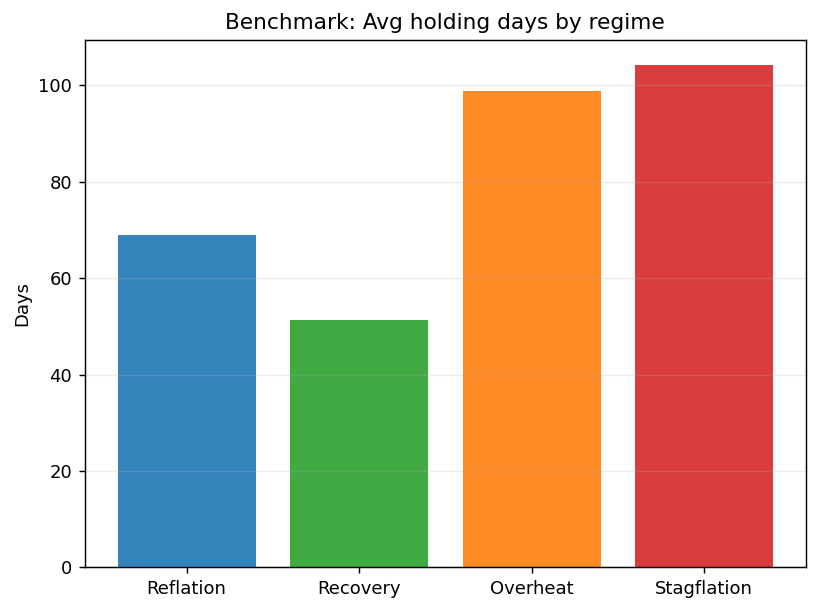

Saved: cache\figures\benchmark_forensics_sum_volume.png


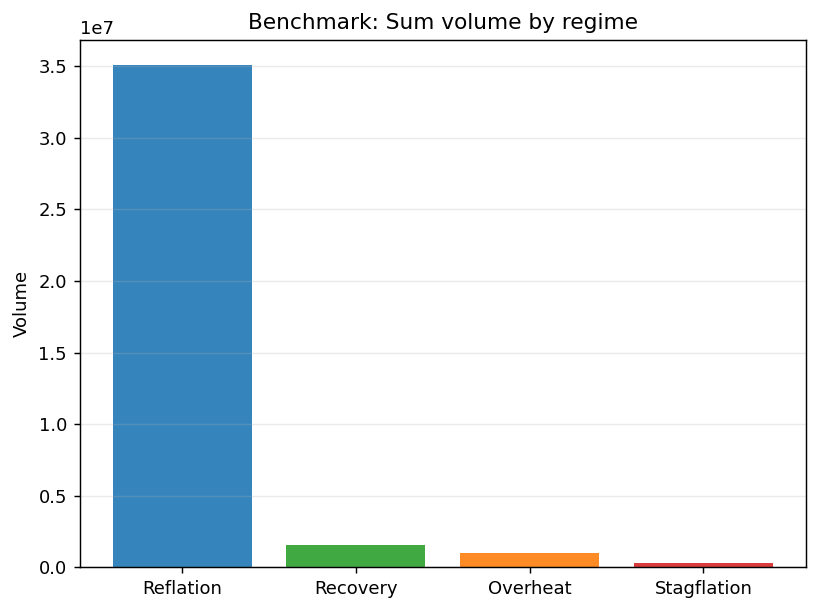

In [8]:
def plot_benchmark_forensics_by_regime(cfg: VizConfig) -> None:
    df = _read_parquet_or_raise(cfg.benchmark_forensics, "benchmark_forensics_by_regime").sort("regime_id")
    pdf = _to_pandas(df)

    def bar(metric: str, title: str, ylabel: str):
        fig, ax = plt.subplots()
        xs = pdf["regime_id"].to_numpy()
        labels = [REGIME_NAMES[int(x)] for x in xs]
        colors = [REGIME_COLORS[int(x)] for x in xs]
        ax.bar(labels, pdf[metric].to_numpy(), color=colors, alpha=0.9)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.grid(True, axis="y", alpha=0.25)
        save_fig(cfg, f"benchmark_forensics_{metric}")
        plt.show()

    # Ajusta los nombres si varían en tu parquet:
    bar("n_trades_open", "Benchmark: Trades opened by regime", "Count")
    bar("unique_algos_traded", "Benchmark: Unique algos traded by regime", "Count")
    bar("avg_holding_days", "Benchmark: Avg holding days by regime", "Days")
    bar("sum_volume", "Benchmark: Sum volume by regime", "Volume")

plot_benchmark_forensics_by_regime(cfg)


Saved: cache\figures\distribution:_n_obs.png


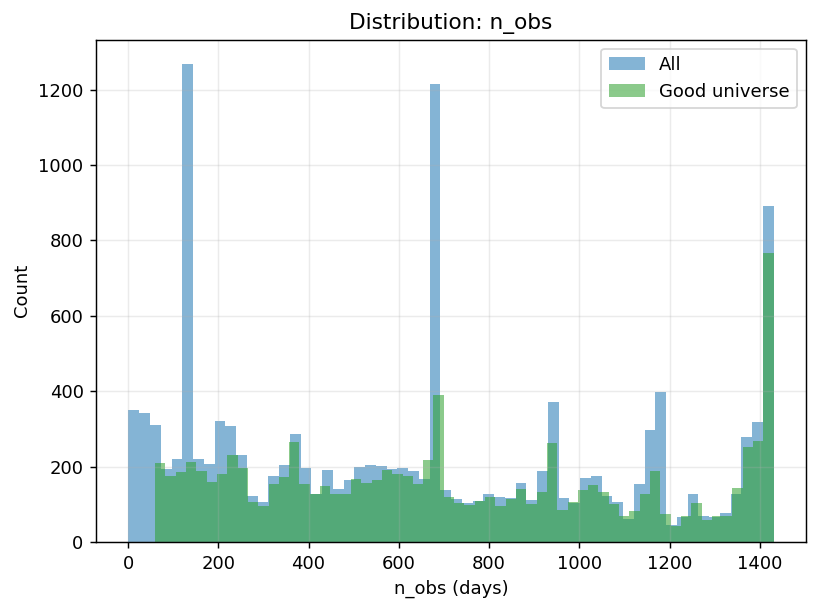

Saved: cache\figures\distribution:_coverage_ratio.png


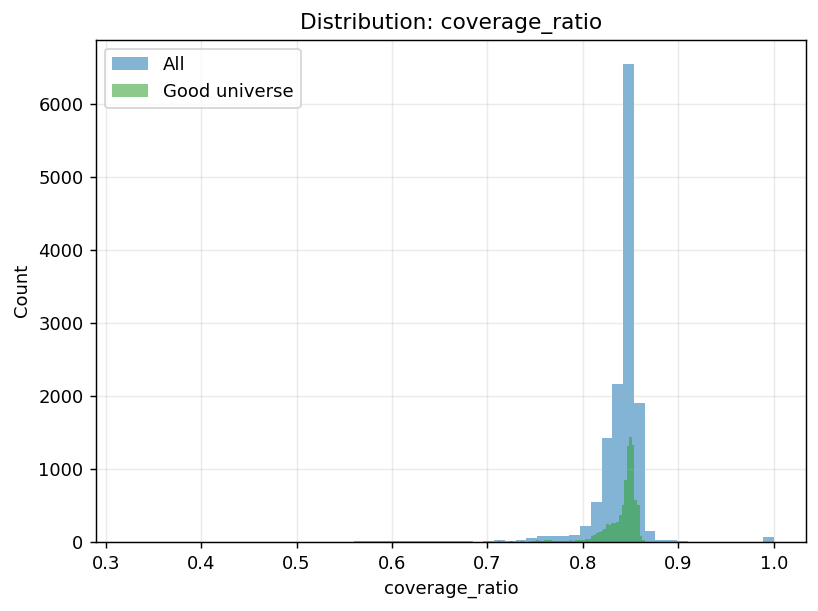

Saved: cache\figures\distribution:_sharpe_ann.png


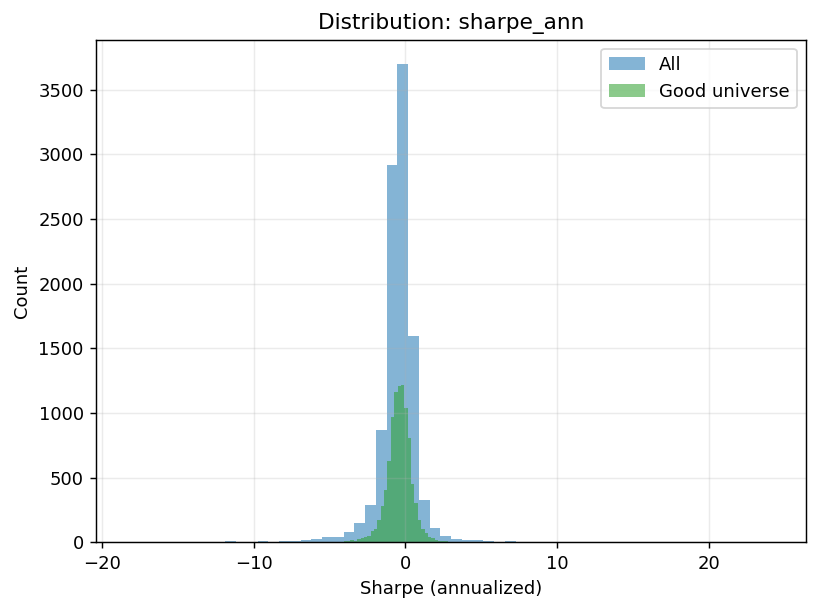

Saved: cache\figures\distribution:_max_drawdown.png


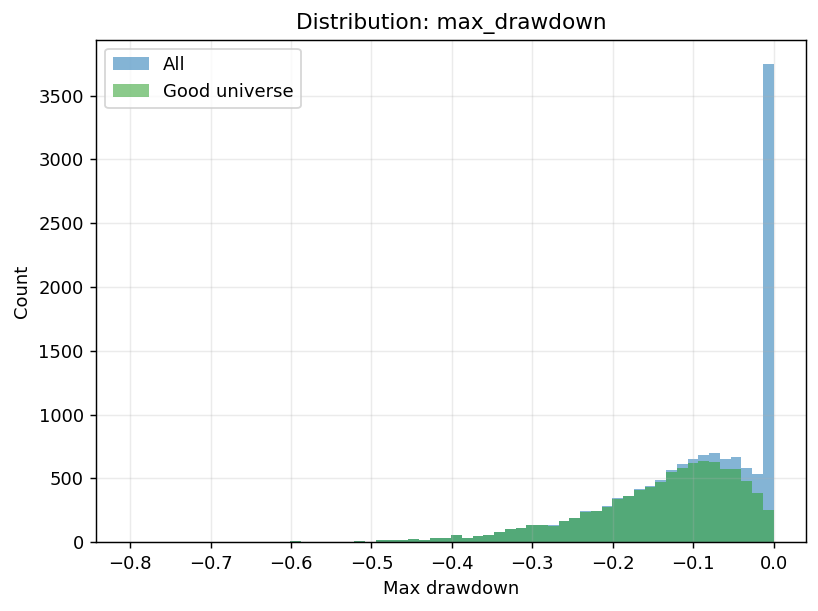

In [9]:
def plot_meta_distributions(cfg: VizConfig) -> None:
    meta = _read_parquet_or_raise(cfg.algos_meta, "algos_meta")
    good = _read_parquet_or_raise(cfg.algos_meta_good, "algos_meta_good")

    def hist(series_all, series_good, title, xlabel, bins=60):
        fig, ax = plt.subplots()
        ax.hist(series_all, bins=bins, alpha=0.55, label="All", color="#1f77b4")
        ax.hist(series_good, bins=bins, alpha=0.55, label="Good universe", color="#2ca02c")
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Count")
        ax.grid(True, alpha=0.25)
        ax.legend(loc="best")
        save_fig(cfg, title.lower().replace(" ", "_"))
        plt.show()

    hist(meta["n_obs"].to_numpy(), good["n_obs"].to_numpy(),
         "Distribution: n_obs", "n_obs (days)")

    hist(meta["coverage_ratio"].to_numpy(), good["coverage_ratio"].to_numpy(),
         "Distribution: coverage_ratio", "coverage_ratio")

    # Si alguna métrica tiene nulls, filtramos
    meta_sh = meta.select(pl.col("sharpe_ann").drop_nulls()).to_series().to_numpy()
    good_sh = good.select(pl.col("sharpe_ann").drop_nulls()).to_series().to_numpy()
    hist(meta_sh, good_sh, "Distribution: sharpe_ann", "Sharpe (annualized)")

    meta_dd = meta.select(pl.col("max_drawdown").drop_nulls()).to_series().to_numpy()
    good_dd = good.select(pl.col("max_drawdown").drop_nulls()).to_series().to_numpy()
    hist(meta_dd, good_dd, "Distribution: max_drawdown", "Max drawdown")

plot_meta_distributions(cfg)


Saved: cache\figures\alive_algos_over_time.png


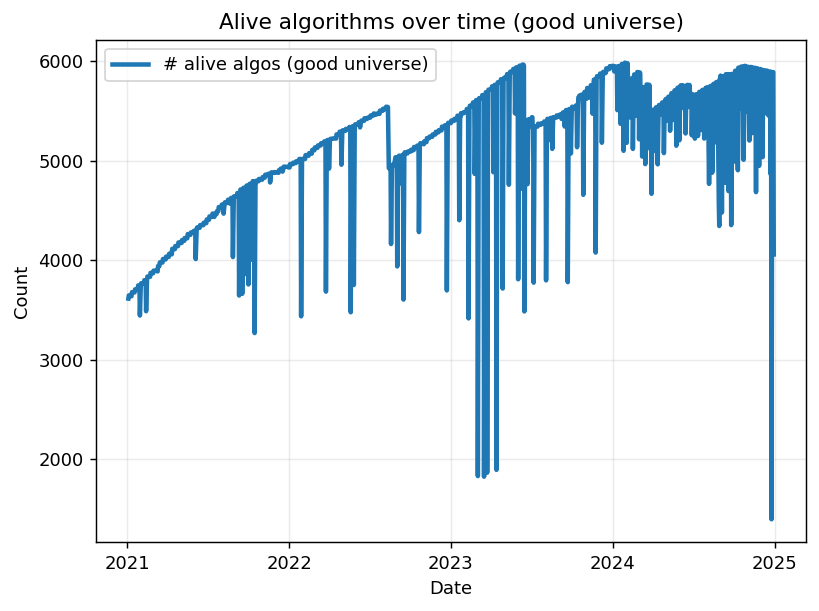

In [10]:
def plot_alive_count_over_time(cfg: VizConfig) -> None:
    lf = pl.scan_parquet(str(cfg.features_macro)).select(["date", "algo_id"])
    agg = (
        lf.group_by("date")
          .agg(pl.col("algo_id").n_unique().alias("n_algos"))
          .sort("date")
          .collect()
    )
    pdf = _to_pandas(agg)

    fig, ax = plt.subplots()
    ax.plot(pdf["date"], pdf["n_algos"], linewidth=2.5, label="# alive algos (good universe)")
    ax.set_title("Alive algorithms over time (good universe)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.25)
    ax.legend(loc="best")
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    save_fig(cfg, "alive_algos_over_time")
    plt.show()

plot_alive_count_over_time(cfg)


C:\Users\maria\AppData\Local\Temp\ipykernel_18240\3003133770.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, showfliers=False)


Saved: cache\figures\sharpe_by_regime_boxplot.png


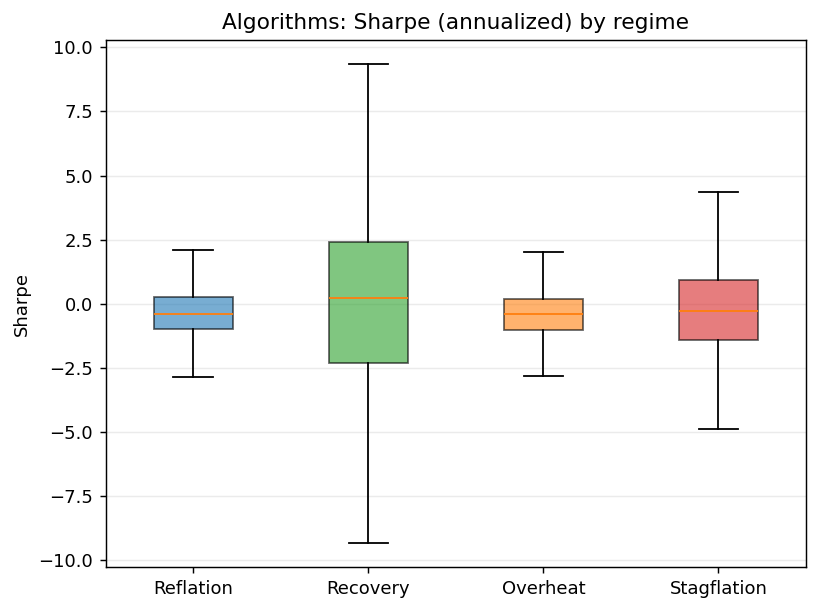

In [11]:
def plot_sharpe_by_regime_boxplot(cfg: VizConfig) -> None:
    prof = _read_parquet_or_raise(cfg.regime_profiles_long, "algo_regime_profiles_long")
    # filtramos nulls
    prof = prof.filter(pl.col("sharpe_ann").is_not_null())

    data = []
    labels = []
    colors = []
    for rid in [0,1,2,3]:
        vals = prof.filter(pl.col("regime_id") == rid).select("sharpe_ann").to_series().to_numpy()
        data.append(vals)
        labels.append(REGIME_NAMES[rid])
        colors.append(REGIME_COLORS[rid])

    fig, ax = plt.subplots()
    bp = ax.boxplot(data, labels=labels, patch_artist=True, showfliers=False)
    for patch, c in zip(bp["boxes"], colors):
        patch.set_facecolor(c)
        patch.set_alpha(0.6)

    ax.set_title("Algorithms: Sharpe (annualized) by regime")
    ax.set_ylabel("Sharpe")
    ax.grid(True, axis="y", alpha=0.25)
    save_fig(cfg, "sharpe_by_regime_boxplot")
    plt.show()

plot_sharpe_by_regime_boxplot(cfg)


Saved: cache\figures\top_algos_reflation.png


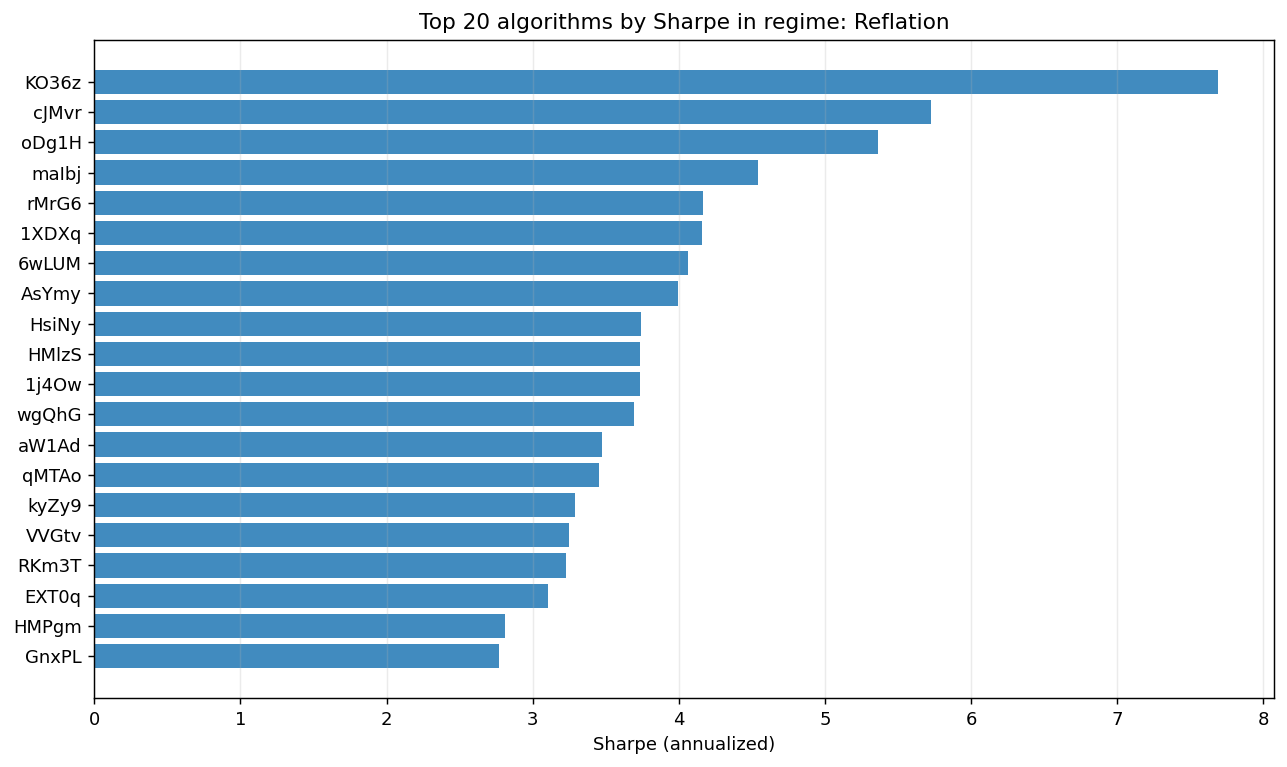

Saved: cache\figures\top_algos_recovery.png


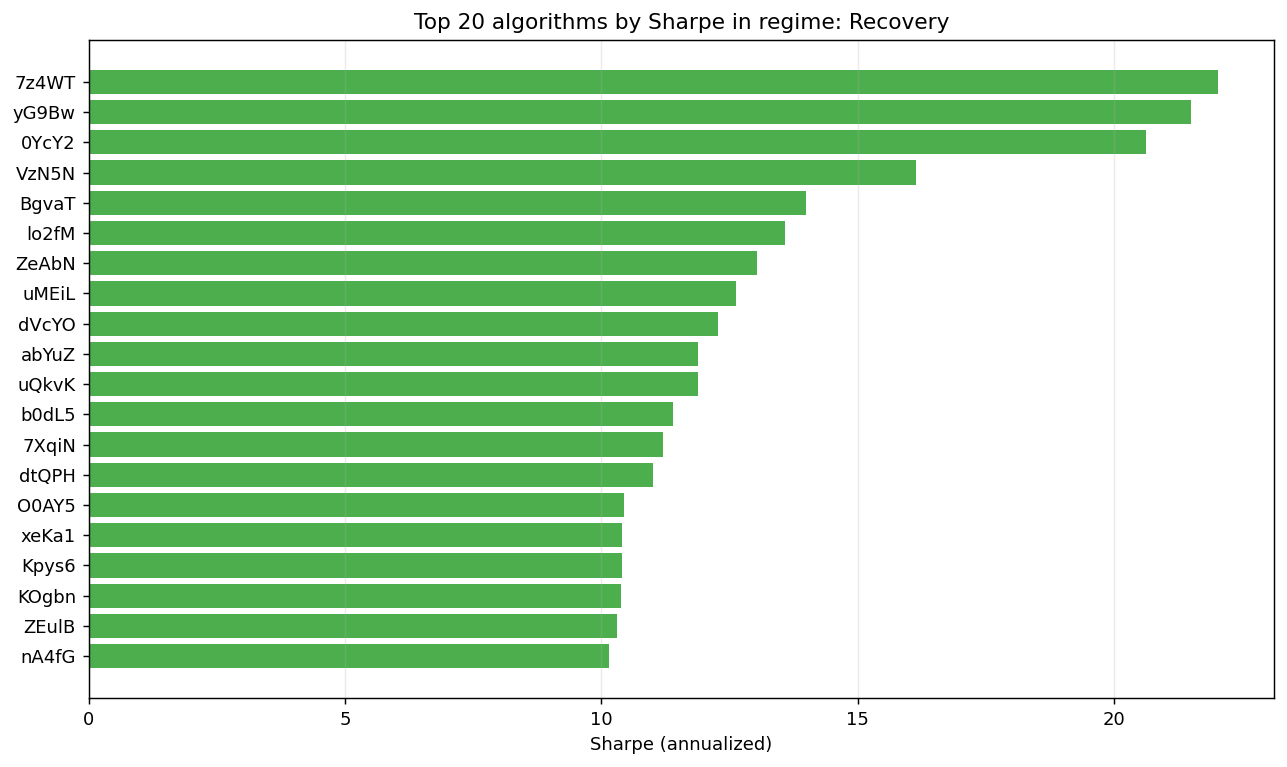

Saved: cache\figures\top_algos_overheat.png


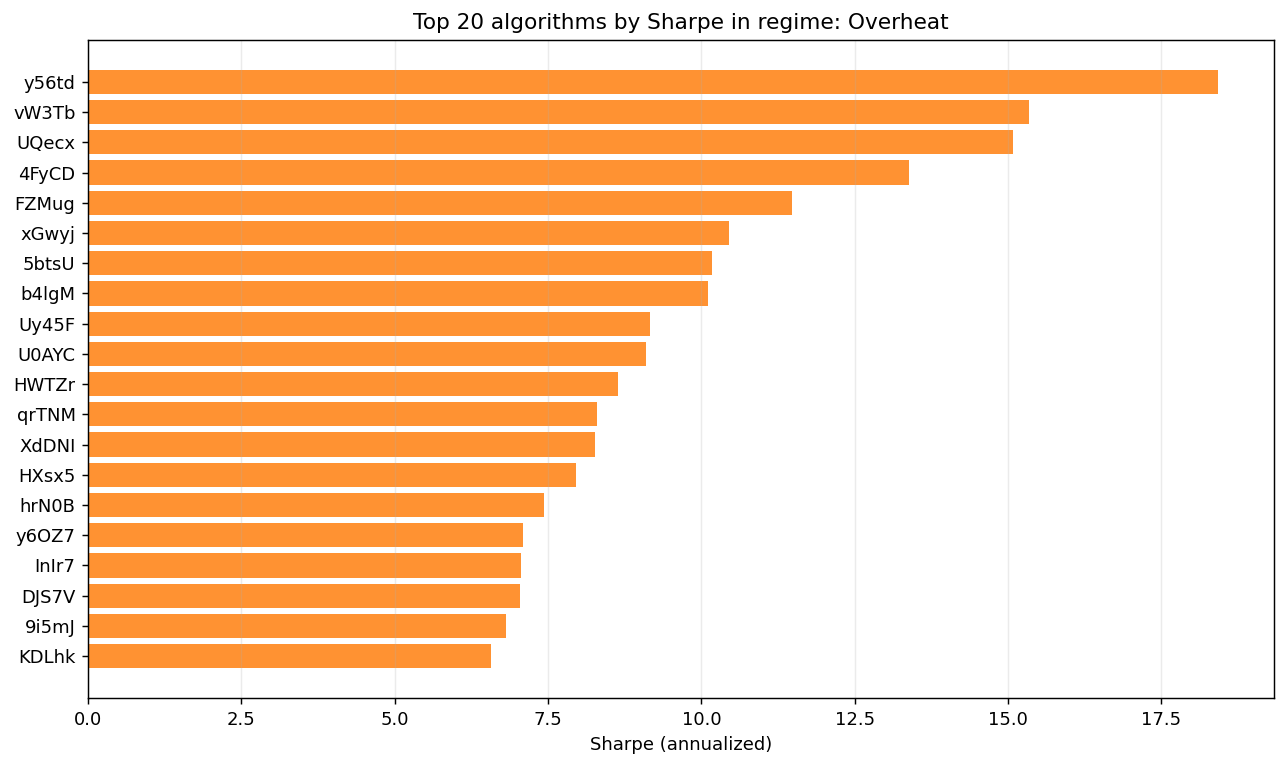

Saved: cache\figures\top_algos_stagflation.png


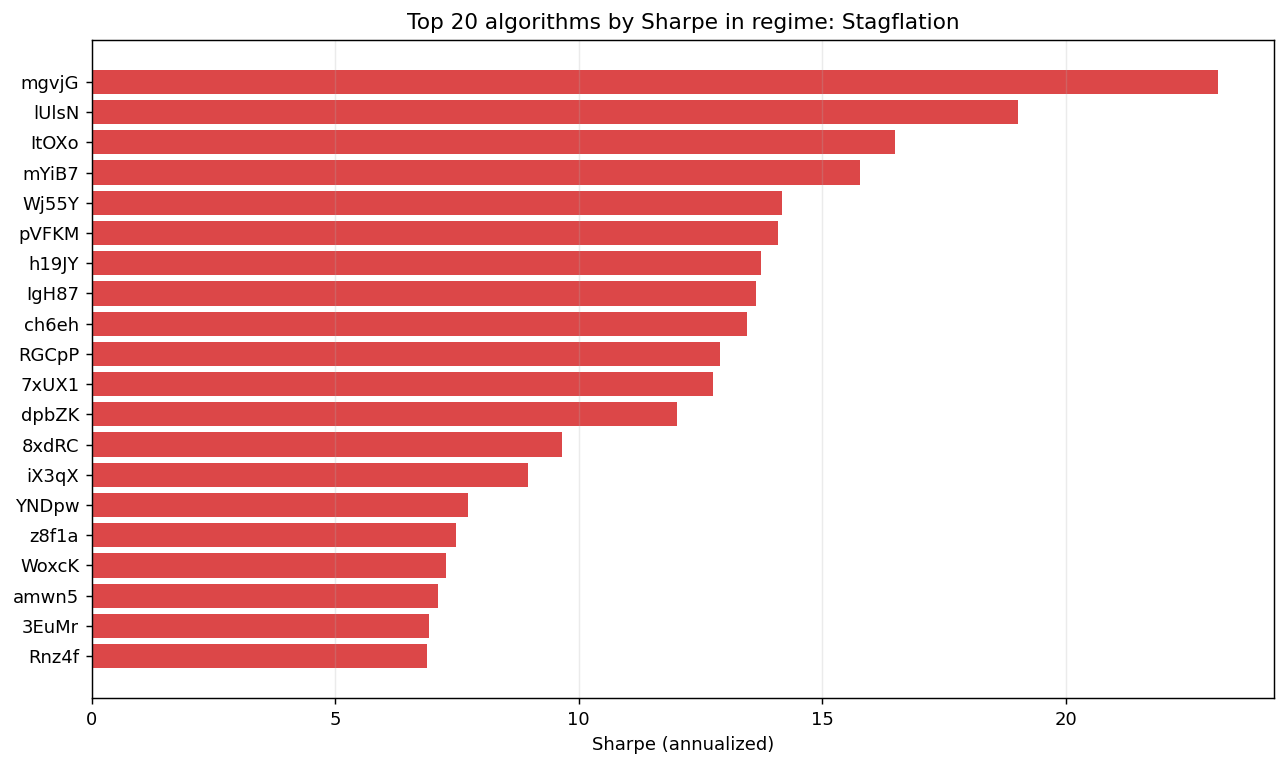

In [12]:
def plot_top_algos_per_regime(cfg: VizConfig, top_n: int = 20) -> None:
    ranks = _read_parquet_or_raise(cfg.regime_rankings, "algo_regime_rankings")
    ranks = ranks.filter(pl.col("rank") <= top_n)

    for rid in [0,1,2,3]:
        sub = ranks.filter(pl.col("regime_id") == rid).sort("rank")
        if sub.height == 0:
            continue

        algo_ids = sub["algo_id"].to_list()
        sharpe = sub["sharpe_ann"].to_numpy()

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.barh(list(reversed(algo_ids)), list(reversed(sharpe)), color=REGIME_COLORS[rid], alpha=0.85)
        ax.set_title(f"Top {top_n} algorithms by Sharpe in regime: {REGIME_NAMES[rid]}")
        ax.set_xlabel("Sharpe (annualized)")
        ax.grid(True, axis="x", alpha=0.25)
        save_fig(cfg, f"top_algos_{REGIME_NAMES[rid].lower()}")
        plt.show()

plot_top_algos_per_regime(cfg, top_n=20)


Saved: cache\figures\cluster_sizes.png


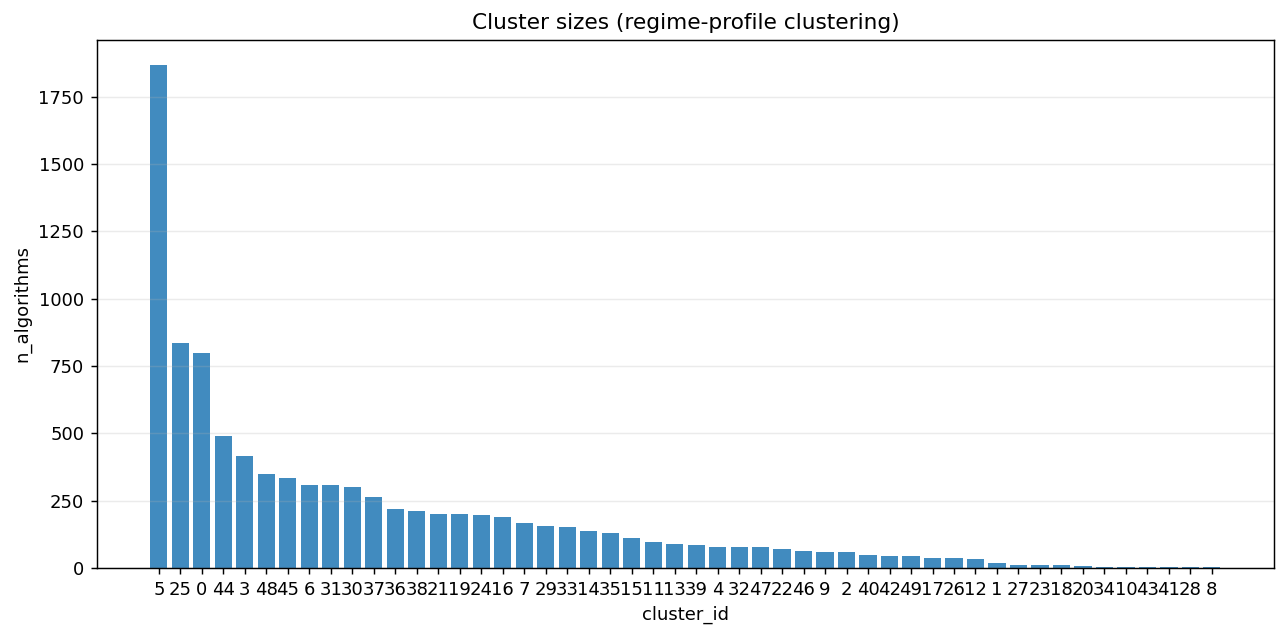

In [13]:
def plot_cluster_sizes(cfg: VizConfig) -> None:
    cl = _read_parquet_or_raise(cfg.clusters, "algo_regime_clusters")
    sizes = cl.group_by("cluster_id").len().sort("len", descending=True)
    pdf = _to_pandas(sizes)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pdf["cluster_id"].astype(str), pdf["len"], alpha=0.85)
    ax.set_title("Cluster sizes (regime-profile clustering)")
    ax.set_xlabel("cluster_id")
    ax.set_ylabel("n_algorithms")
    ax.grid(True, axis="y", alpha=0.25)
    save_fig(cfg, "cluster_sizes")
    plt.show()

plot_cluster_sizes(cfg)


Saved: cache\figures\profiles_pca_clusters.png


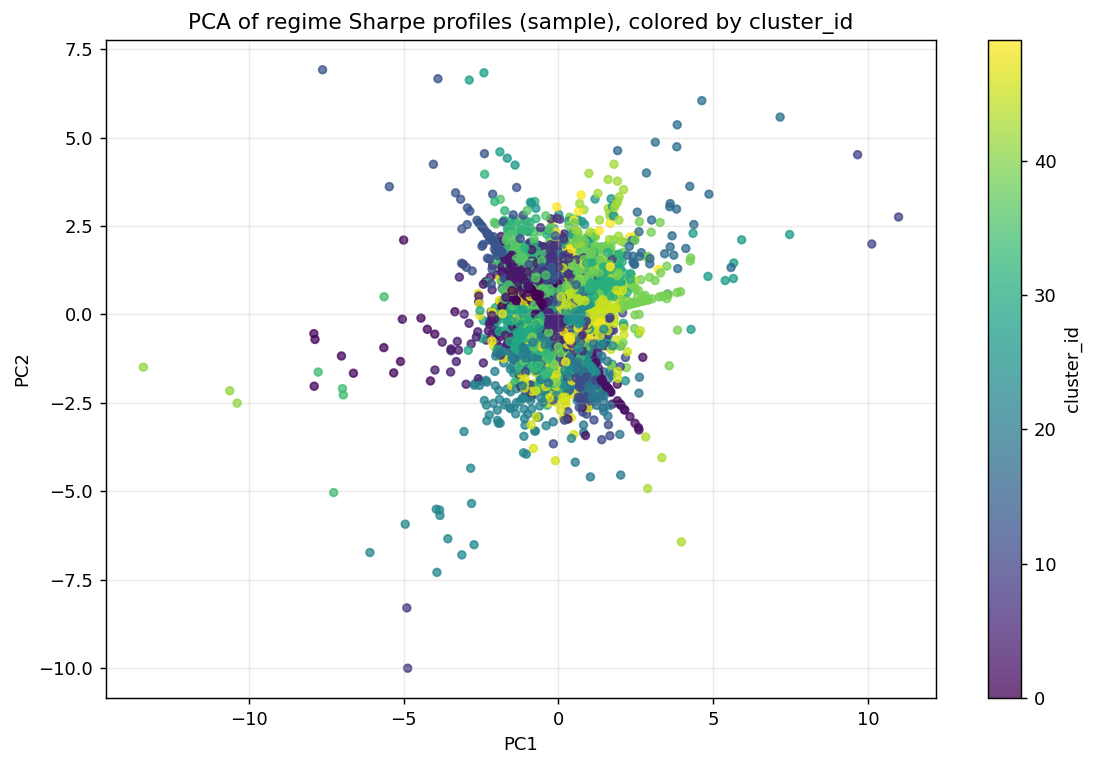

In [14]:
def plot_profile_pca_scatter(cfg: VizConfig, sample_n: int = 8000, seed: int = 42) -> None:
    prof = _read_parquet_or_raise(cfg.regime_profiles_wide, "algo_regime_profiles_wide")
    cl = _read_parquet_or_raise(cfg.clusters, "algo_regime_clusters")

    df = prof.join(cl, on="algo_id", how="inner")
    if df.height > sample_n:
        df = df.sample(sample_n, seed=seed)

    X = df.select(["sharpe_reflation", "sharpe_recovery", "sharpe_overheat", "sharpe_stagflation"]).to_numpy()
    labels = df["cluster_id"].to_numpy()

    # Normalización
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-9
    Xn = (X - mu) / sd

    # PCA 2D (SVD)
    U, S, Vt = np.linalg.svd(Xn, full_matrices=False)
    Z = Xn @ Vt[:2].T  # (n,2)

    fig, ax = plt.subplots(figsize=(9, 6))
    # Colorear por cluster: si hay muchos clusters, el color será “cíclico” (aceptable para overview)
    sc = ax.scatter(Z[:,0], Z[:,1], c=labels, s=18, alpha=0.75)
    ax.set_title("PCA of regime Sharpe profiles (sample), colored by cluster_id")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(True, alpha=0.25)
    plt.colorbar(sc, ax=ax, label="cluster_id")
    save_fig(cfg, "profiles_pca_clusters")
    plt.show()

plot_profile_pca_scatter(cfg, sample_n=8000)
